# Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.  
Using this model, BigMart will try to understand:
## What is the properties of products and stores which play a key role in increasing sales?


#### import libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn as sk
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#### Load the dataset

In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
train['source']='train'
test['source']='test'
df = pd.concat([train, test],ignore_index=True,sort = True)

### 1)Data preprocessing

#### Visualize some features of the dataset

In [3]:
categorical_columns = [df[x].value_counts() for x in df.dtypes.index if df.dtypes[x]=='object']
for x in categorical_columns:
    print(x)

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
DRL01    10
NCF30    10
NCK29    10
DRH37    10
NCA29    10
FDC21    10
FDT34    10
FDF16    10
FDD16    10
FDH56    10
NCK31    10
FDH04    10
NCK53    10
FDZ16    10
FDZ48    10
FDU12    10
FDM44    10
DRL60    10
DRC36    10
DRG37    10
FDO57    10
NCW42    10
FDS40    10
FDY39    10
DRA59    10
FDX09    10
FDZ26    10
FDA13    10
FDC28    10
DRC25    10
         ..
FDW60     8
FDF35     8
FDX15     8
FDD35     8
FDX33     8
FDT26     8
FDF53     8
NCC19     8
FDL08     8
FDV07     8
FDA11     8
FDT38     8
FDQ44     8
FDS16     8
FDC11     8
DRE12     8
FDG05     8
FDH58     7
FDL50     7
FDM10     7
FDS22     7
FDR51     7
FDX49     7
FDM50     7
FDO33     7
NCL42     7
FDI46     7
FDM52     7
DRN11     7
NCW54     7
Name: Item_Identifier, Length: 1559, dtype: int64
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Food

In [4]:
df.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

#### Cleaning some data

In [5]:
df = df.replace(to_replace =["LF","low fat"], value ="Low Fat" )
df = df.replace(to_replace ="reg" , value ="Regular")

#### Count the Na value

In [6]:
df.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

#### Define a function that allow us to fill na value based on another column

In [7]:
def fill_na_based_on_another_column(df,x,y):
	dff = df[[x,y]].dropna()
	dic,k,j,i= dict(zip(dff[x],dff[y])),df.columns.get_loc(x),df.columns.get_loc(y),0
	for a in df[y]:
		if math.isnan(float(a)):
			if df.iloc[i,k] in dic.keys():
				df.iloc[i,j] = dic[df.iloc[i,k]]
			else :
				df.iloc[i,j] = df[y].mean()
		i+=1


#### Filling the na value

In [8]:
fill_na_based_on_another_column(df,"Item_Identifier","Item_Weight")
df["Item_Weight"] = df["Item_Weight"].fillna(df["Item_Weight"].mean())
t = df['Outlet_Size'].dropna().unique().tolist()
df["Outlet_Size"] = df["Outlet_Size"].replace(t,[0,1,2])
df["Outlet_Size"] = df["Outlet_Size"].apply(lambda x: np.random.choice(df["Outlet_Size"].dropna().values) if np.isnan(x) else x)
df["Outlet_Size"] = df["Outlet_Size"].replace([0,1,2],t)

#### No more mising value

In [9]:
df.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64

#### Modify Item_visibility

In [10]:
sum(df['Item_Visibility'] == 0)
df['Item_Visibility'] = df['Item_Visibility'].replace(0,np.nan)
df['Item_Visibility']=df['Item_Visibility'].fillna(df['Item_Visibility'].mean())

#### Edit the variable Item_Type

In [11]:
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda x: x[0:2])
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
df['Item_Type_Combined'].value_counts()
df.loc[df['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
df['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

#### Create a new variable depicting the years of operation of a store.

In [12]:
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']
df['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

### 2)Visualization of some features

#### Numerical data

In [13]:
num = df._get_numeric_data().drop('Outlet_Establishment_Year',1)[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Years','Item_Outlet_Sales']]
num.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.070303,141.004977,15.169319,2181.288914
std,4.651716,0.048590,62.086938,8.371664,1706.499616
min,4.555000,0.003575,31.290000,4.000000,33.290000
25%,8.710000,0.033143,94.012000,9.000000,834.247400
50%,12.600000,0.062347,142.247000,14.000000,1794.331000
75%,16.750000,0.094037,185.855600,26.000000,3101.296400
max,21.350000,0.328391,266.888400,28.000000,13086.964800


#### Correlation matrix

In [14]:
corr = num.corr()
corr.style.background_gradient(cmap='coolwarm')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Outlet_Sales
Item_Weight,1,-0.0203385,0.0357512,-0.000247206,0.0132612
Item_Visibility,-0.0203385,1,-0.00892882,0.0886189,-0.134041
Item_MRP,0.0357512,-0.00892882,1,-0.000141378,0.567574
Outlet_Years,-0.000247206,0.0886189,-0.000141378,1,0.049135
Item_Outlet_Sales,0.0132612,-0.134041,0.567574,0.049135,1


#### Categorical data

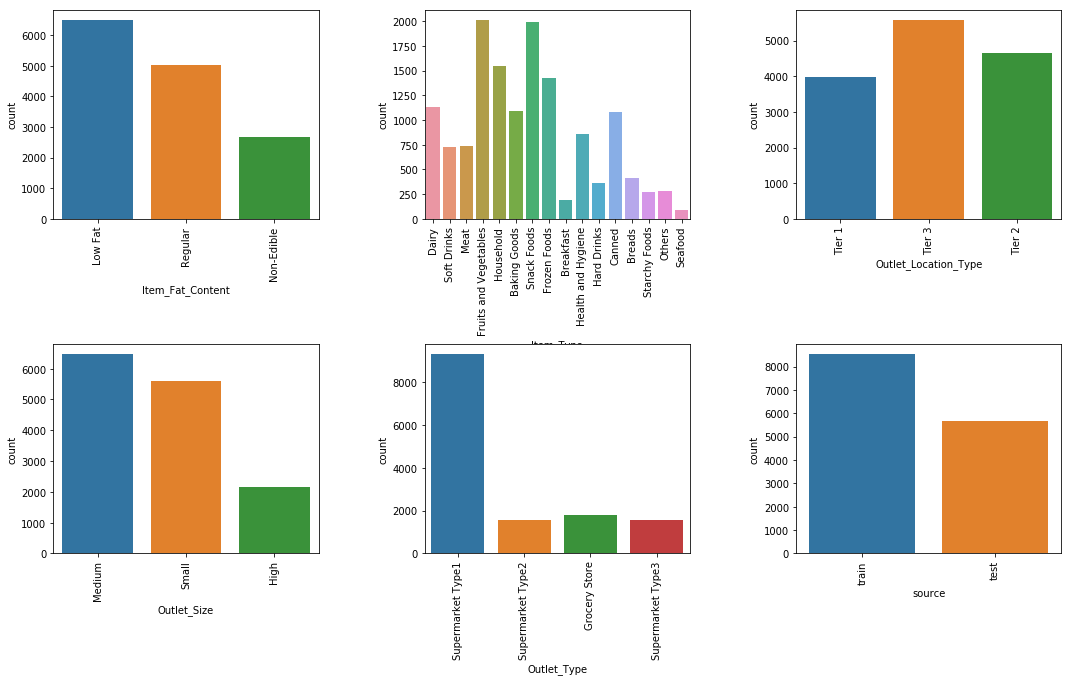

In [15]:
cat = df.select_dtypes(include='object').drop(["Item_Identifier","Outlet_Identifier"],1)
fig, ax = plt.subplots(2,3, figsize=(20, 10))
for variable, subplot in zip(cat, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
fig.subplots_adjust(left=0.2, wspace=0.4, hspace = 0.6)
cat["Item_Outlet_Sales"] = df["Item_Outlet_Sales"]
cat['Outlet_Identifier'] = df['Outlet_Identifier']

#### The distribution of the different type of Item

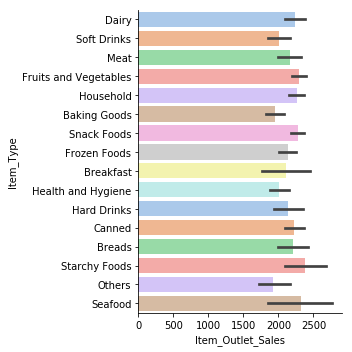

In [16]:
sns.catplot(y="Item_Type",x="Item_Outlet_Sales", data=cat,kind = "bar",palette="pastel");

#### Distribution of product types by store

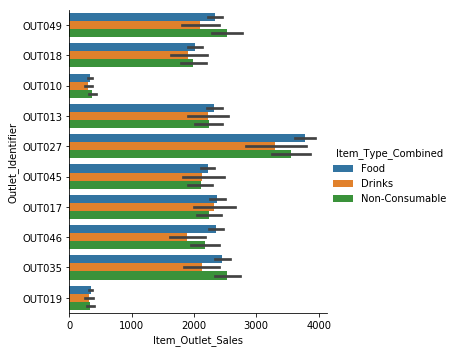

In [17]:
sns.catplot(y="Outlet_Identifier",x="Item_Outlet_Sales", hue="Item_Type_Combined", kind="bar", data=cat);

#### Distribution of the type of the city in which the store is located by outlet 

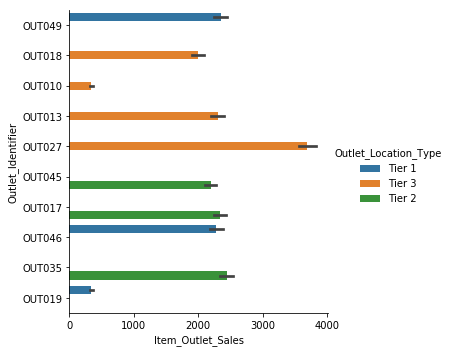

In [18]:
sns.catplot(y="Outlet_Identifier",x="Item_Outlet_Sales", hue="Outlet_Location_Type", kind="bar", data=cat);

#### Distribution of the Outlet's size by store 

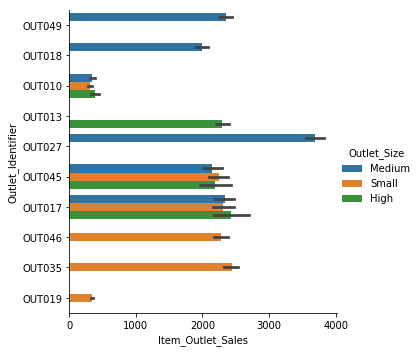

In [19]:
sns.catplot(y="Outlet_Identifier",x="Item_Outlet_Sales", hue="Outlet_Size", kind="bar", data=cat);

### 3)Building Model

#### Numerical and One-Hot Coding of Categorical variables

##### Lets start with coding all categorical variables as numeric

In [20]:
le = LabelEncoder()
#New variable for outlet
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [21]:
#One Hot Coding:
df = pd.get_dummies(df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])
df.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
O

In [22]:
df[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


In [33]:
#Drop the columns which have been converted to different types:
df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = df.loc[df['source']=="train"]
test = df.loc[df['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Define a function which make the model, perform cross-validation and generate submission 

In [34]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
def modelfit(alg, dtrain, dtest, predictors, target, IDcol):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score =  cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20)
    cv_score = np.sqrt(np.abs(cv_score))

    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

    

#### Linear Regression Model


Model Report
RMSE : 1128
CV Score : Mean - 0.7474 | Std - 0.01943 | Min - 0.6973 | Max - 0.7845


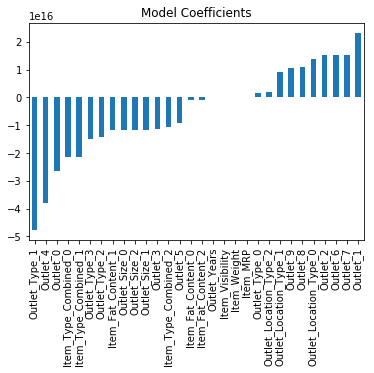

In [35]:

predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol)
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


#### Ridge Regression Model:


Model Report
RMSE : 1129
CV Score : Mean - 0.747 | Std - 0.0181 | Min - 0.7035 | Max - 0.7825


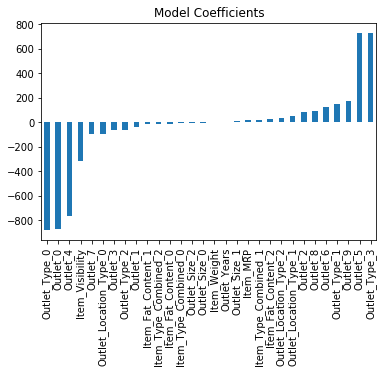

In [37]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol)
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

#### Decision Tree Model


Model Report
RMSE : 1060
CV Score : Mean - 0.7666 | Std - 0.02516 | Min - 0.7058 | Max - 0.8162


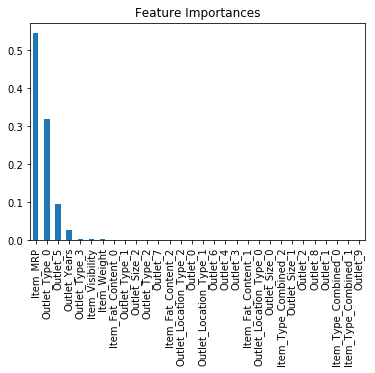

In [40]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol)
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

Here you can see that the RMSE is 1058 and the mean CV error is 1091. This tells us that the model is slightly overfitting. Lets try making a decision tree with just top 4 variables, a max_depth of 8 and min_samples_leaf as 150.


Model Report
RMSE : 1071
CV Score : Mean - 0.7635 | Std - 0.02464 | Min - 0.7032 | Max - 0.8087


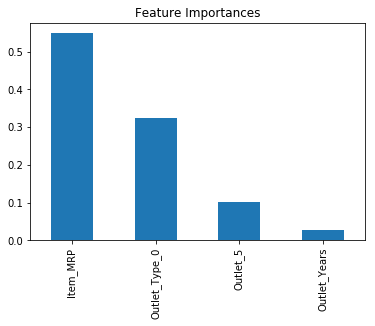

In [42]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol)
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

#### Random Forest Model

In [ ]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol)
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')